In [9]:
import matplotlib.pyplot as plt
import numpy as np
from mne.decoding import CSP
from sklearn.model_selection import train_test_split
from pyriemann.estimation import Covariances
from pyriemann.classification import MDM
from pyriemann.tangentspace import TangentSpace

from processing.preprocessing import BCIDataProcessor

recording_path_1 = '../recordings/recording_imagery2.raw.fif'
recording_path_2 = '../recordings/recording_imagery3.raw.fif'
rescale = True
window_size = 2
window_overlap = 0.16
filter_method = 'iir'
l_freq, h_freq = 10, 20

processor = BCIDataProcessor(recording_path_1, l_freq=l_freq, h_freq=h_freq, window_size=window_size,
                             window_overlap=window_overlap, rescale=rescale, filter_method=filter_method)
data = processor.process()
data = {label: data[label] for label in data.keys() if label in ['left_hand', 'right_hand']}
data

{'right_hand': array([[[-1.78846999e-09,  6.30567879e-06,  1.16518130e-05, ...,
          -3.92059735e-06, -7.36053197e-06, -1.00570533e-05],
         [-1.89246174e-09,  4.27792444e-06,  7.83443623e-06, ...,
          -1.90063732e-06, -3.66020367e-06, -5.23078033e-06],
         [-2.03974892e-09,  1.06045180e-06,  1.84376525e-06, ...,
          -2.71053282e-07, -5.51964937e-07, -9.37275899e-07],
         ...,
         [-2.37185595e-09,  6.36337773e-06,  1.17237903e-05, ...,
          -3.59583331e-06, -6.19540923e-06, -8.29167081e-06],
         [-1.03730482e-09,  2.08543951e-06,  3.78387095e-06, ...,
           1.26947444e-06,  7.66948453e-07, -4.11351650e-08],
         [-3.13870238e-10, -4.40243342e-07, -8.98706149e-07, ...,
           3.66682701e-06,  3.77740688e-06,  3.32080987e-06]],
 
        [[ 3.15298761e-06,  2.10792991e-06,  1.11507667e-06, ...,
          -5.03943128e-06, -4.47529889e-06, -3.49357751e-06],
         [ 2.96595134e-06,  3.33265645e-06,  3.34664489e-06, ...,
       

In [10]:
X = np.concatenate(list(data.values()), axis=0)
y = np.concatenate([[label] * data[label].shape[0] for label in data.keys()])  # (samples,)
X.shape, y.shape

((48, 8, 500), (48,))

In [11]:
from sklearn.pipeline import Pipeline

clf = Pipeline(steps=[('cov', Covariances(estimator='oas')),
                      ('mdm', MDM(metric=dict(mean='logeuclid', distance='riemann')))])
clf.fit(X, y)
y_pred = clf.predict(X)
print(f"Training accuracy: {np.mean(y_pred == y)}")

Training accuracy: 0.7083333333333334


In [12]:
# Load the second recording and validate on that
processor = BCIDataProcessor(recording_path_2, l_freq=l_freq, h_freq=h_freq, window_size=window_size,
                             window_overlap=window_overlap, rescale=rescale, filter_method=filter_method)
data = processor.process()
data = {label: data[label] for label in data.keys() if label in ['left_hand', 'right_hand']}
data

{'left_hand': array([[[-3.98280567e-09, -5.95400443e-06, -1.11152826e-05, ...,
          -6.30254016e-06, -3.96540674e-06, -1.12968992e-06],
         [-4.36485050e-09, -3.73149118e-06, -7.09237192e-06, ...,
          -2.78692718e-06, -1.71126404e-06, -5.67924450e-07],
         [-1.86748072e-09, -2.85125552e-06, -5.36302844e-06, ...,
           2.10228285e-06,  1.84884612e-06,  1.34050567e-06],
         ...,
         [-5.48018237e-09, -7.72227958e-06, -1.44214457e-05, ...,
          -6.47027228e-06, -4.06617132e-06, -1.56435847e-06],
         [-2.58562582e-09, -2.62678896e-06, -5.01115216e-06, ...,
           1.28325177e-06,  2.48835064e-06,  3.34265544e-06],
         [-1.47861270e-09, -2.73634990e-07, -6.19729265e-07, ...,
           3.62271214e-06,  3.75491405e-06,  3.46388042e-06]],
 
        [[-4.71622194e-07,  2.64462173e-06,  5.86132117e-06, ...,
           1.91107521e-07,  8.24057739e-08,  2.26221045e-07],
         [-3.34334743e-06, -2.80418866e-06, -1.82762873e-06, ...,
        

In [13]:
# Prepare the data for validation
X_val = np.concatenate(list(data.values()), axis=0)
y_val = np.concatenate([[label] * data[label].shape[0] for label in data.keys()])  # (samples,)

# Evaluate the trained model on the validation data
val_score = clf.score(X_val, y_val)
print(f"Validation accuracy: {val_score}")

Validation accuracy: 0.6666666666666666


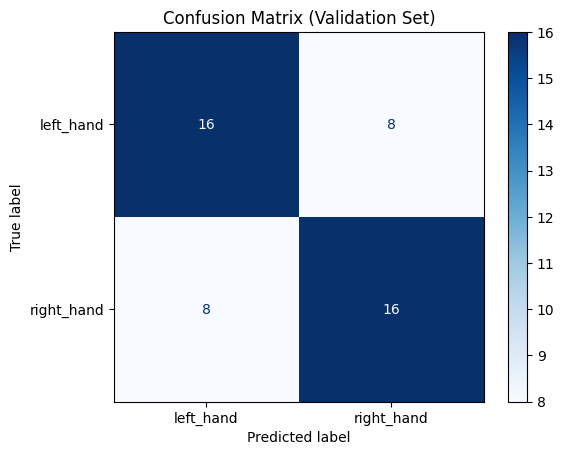

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions for the validation data
y_val_pred = clf.predict(X_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_val))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Validation Set)")
plt.show()